# Cloud Detection
Dataset: https://zenodo.org/record/4172871#.ZGc19-zP23J

In [37]:
!pip install -q geopandas folium contextily

## Auth

In [1]:
%load_ext dotenv
%dotenv ./key.env -o -v

## Import 

In [38]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box, from_file
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import minimize
from sklearn.metrics import jaccard_score
import cv2
import seaborn as sns
import geopandas as gpd
import folium
import contextily as cx

from sklearn.model_selection import StratifiedKFold, KFold
import torch
print(torch.__version__)
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
import segmentation_models_pytorch as smp
# from torchmetrics import FBetaScore
import ttach as tta

import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger, CSVLogger
from pytorch_lightning import LightningDataModule, LightningModule

import wandb
wandb.login(key=os.environ["WANDB_API_KEY"])

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ss/.netrc


1.10.1+cu113
1.6.0


## Config

In [12]:
from typing import List, Set, Dict, Any

base_channel = 16

class CFG(object):
    # basic
    debug: bool = False
    debug_sample: int = 64
    folds: int  = 4
    seed: int   = 417
    eps: float  = 1e-12
    
    SINGLE_FOLD = True
    
    # data
    PATH_CSV: str  =  f'../data/cloud/classification_tags.csv'
    
    # train
    epoch: int  = 400
    # early_stop_patience:int = int(epoch /10)
    trainer: Dict[str, Any]   = {
        'gpus': 1,
        'accumulate_grad_batches': 1,
        'progress_bar_refresh_rate': 1,
        'stochastic_weight_avg': False,
        'fast_dev_run': False,
        'num_sanity_val_steps': 0,
        'resume_from_checkpoint': None,
        'check_val_every_n_epoch': 2,
        'val_check_interval': 1.0,
        # 'precision' : 16,
        'gradient_clip_val': 15., 
        'gradient_clip_algorithm': "value"
    }
    optimizer: Dict[str, Any] = {
        'name': 'optim.AdamW',
        'params': {
            'lr': 1e-3,
            },
    }
    scheduler: Dict[str, Any] = {
        'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
        'params':{
            'T_0': int(epoch/2),
            'eta_min': 1e-5,
            }
    }
    
    base_channel = base_channel # python bug?
    model: Dict[str, Any] = {
        'timmunet': {
                'encoder_params': {  
                    "encoder": "hrnet_w30",
                    "decoder_filters": [base_channel * i for i in range(1, 4)],
                    "last_upsample": base_channel,
                },
        },
        'loss': 'BCEDiceLoss()',
        'threshold': 0.4,
    }
    
    BATCH_SIZE = 32
    train_loader: Dict[str, Any] = {
        'batch_size': BATCH_SIZE,
        'shuffle': True,
        'num_workers': 8,
        'pin_memory': False,
        'drop_last': True,
    }
    val_loader :Dict[str, Any]= {
        'batch_size': BATCH_SIZE*2,
        'shuffle': False,
        'num_workers': 8,
        'pin_memory': False,
        'drop_last': False
    }
    
    MIXUP_RATIO = 1

    
    preprocess: Dict = {
        "input_size": 512,
    }
    
    ENV = 'A6000'
    VERSION = 1
    outdir: str = f'output/cloud/V{VERSION}/'
    
    info = 'C_'
    # model info
    info += f'{model["timmunet"]["encoder_params"]["encoder"]}'
    info += f'BC{base_channel}TH{model["threshold"]}'
    # train info
    info += f'_LR{optimizer["params"]["lr"]}'
    info += f'T0{scheduler["params"]["T_0"]}'
    info += f'MIX{MIXUP_RATIO}B{train_loader["batch_size"]}_fl-tr'
    
    # logging
    project: str = "ChaBuD-ECML-PKDD2023_Cloud"
    runname: str = f"{ENV}"
    group: str   = f'{ENV}_V{VERSION}_{info}'
    notebook: str = '007_cloud_model.ipynb'
    
    # post info
    augmentation: str =  ''
    fold: int = -1
        

    if debug:
        epoch = 2
        group = 'DEBUG'


# box
cfg = Box({k:v for k, v in dict(vars(CFG)).items() if '__' not in k})
    
# 乱数のシードを設定
seed_everything(cfg.seed)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)

os.makedirs(cfg.outdir, exist_ok=True)
    
pprint(cfg)

Global seed set to 417


{'BATCH_SIZE': 32,
 'ENV': 'A6000',
 'MIXUP_RATIO': 1,
 'PATH_CSV': '../data/cloud/classification_tags.csv',
 'SINGLE_FOLD': True,
 'VERSION': 1,
 'augmentation': '',
 'base_channel': 16,
 'debug': False,
 'debug_sample': 64,
 'epoch': 400,
 'eps': 1e-12,
 'fold': -1,
 'folds': 4,
 'group': 'A6000_V1_C_hrnet_w30BC16TH0.4_LR0.001T0200MIX1B32_fl-tr',
 'info': 'C_hrnet_w30BC16TH0.4_LR0.001T0200MIX1B32_fl-tr',
 'model': {'loss': 'BCEDiceLoss()',
           'threshold': 0.4,
           'timmunet': {'encoder_params': {'decoder_filters': BoxList([16, 32, 48]),
                                           'encoder': 'hrnet_w30',
                                           'last_upsample': 16}}},
 'notebook': '007_cloud_model.ipynb',
 'optimizer': Box({'name': 'optim.AdamW', 'params': {'lr': 0.001}}),
 'outdir': 'output/cloud/V1/',
 'preprocess': Box({'input_size': 512}),
 'project': 'ChaBuD-ECML-PKDD2023_Cloud',
 'runname': 'A6000',
 'scheduler': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRe

In [11]:
df = pd.read_csv(cfg.PATH_CSV)
# print(df.shape, df.columns)
df.head(4)

,index,scene,difficulty,annotator,shadows_marked,clear_percent,cloud_percent,shadow_percent,dataset,forest/jungle,...,high,isolated,extended,cumulus,cumulonimbus,altocumulus/stratocumulus,cirrus,haze/fog,ice_clouds,contrails
0,0,S2A_MSIL1C_20180101T010721_N0206_R045_T53HLD_20180101T041600,1,A,1,0.000000,100.000000,0.000000,MAIN,0,...,0,0,1,1,0,1,0,0,0,0
1,1,S2A_MSIL1C_20180101T074231_N0206_R049_T37LDJ_20180101T111527,4,B,1,2.857105,94.907629,2.235266,MAIN,0,...,1,0,1,1,0,1,1,0,1,0
2,2,S2A_MSIL1C_20180102T084341_N0206_R064_T36TVP_20180102T110333,4,B,1,75.115464,15.194967,9.689569,MAIN,0,...,0,1,0,1,0,0,0,0,0,0
3,3,S2A_MSIL1C_20180107T111431_N0206_R137_T31VEE_20180107T130945,2,B,1,0.000000,99.540539,0.459461,MAIN,0,...,0,0,1,1,0,1,0,0,0,0


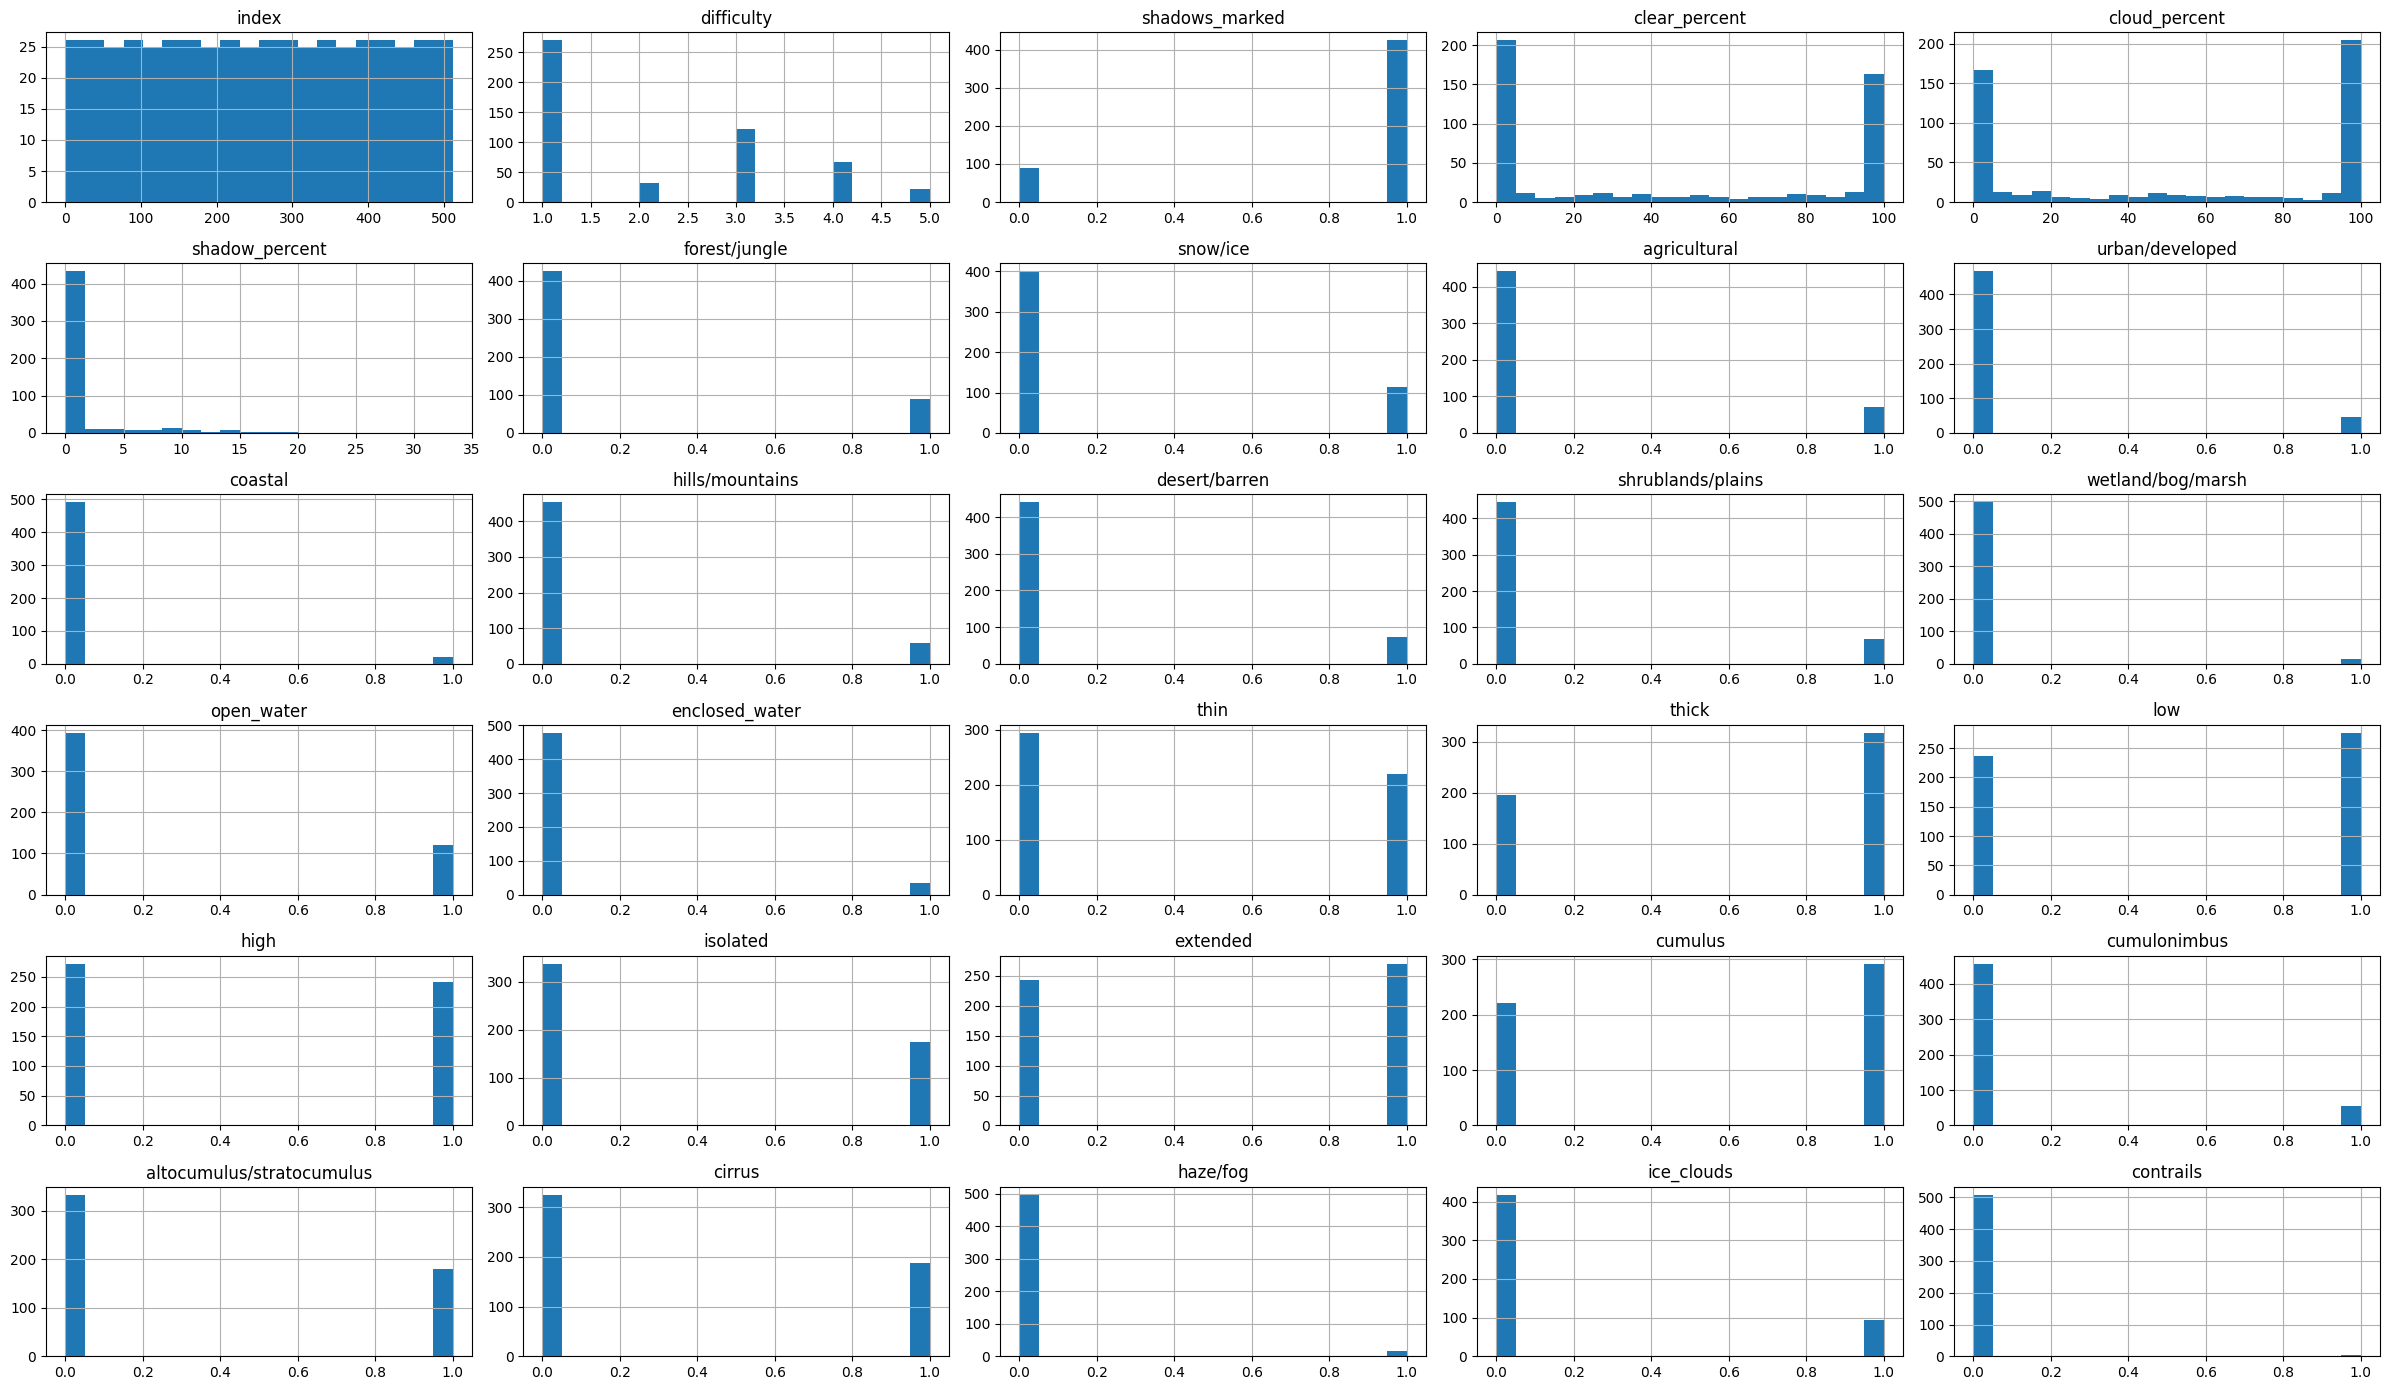

In [13]:
df.hist(figsize=(24, 14), bins=20)
plt.tight_layout() 
plt.savefig(f'{cfg.outdir}/hist.png')
plt.show();

uint8 (512, 512, 3)
float32 (1022, 1022, 3)


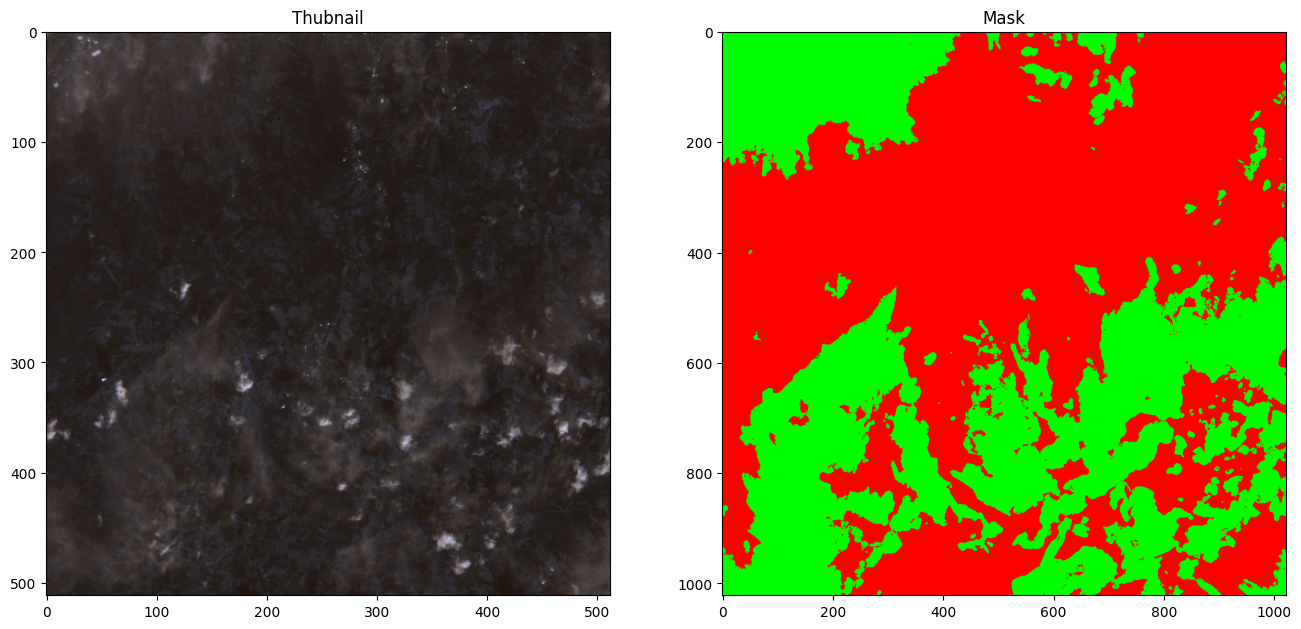

In [59]:
idx = 24

row = df.iloc[idx]
scene = row['scene']

img_thum = cv2.imread(f'../data/cloud/thumbnails/{scene}.png')
print(img_thum.dtype, img_thum.shape)
mask = np.load(f'../data/cloud/masks/{scene}.npy').astype(np.float32)
print(mask.dtype, mask.shape)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title('Thubnail')
plt.imshow(img_thum)

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)

plt.savefig(f'{cfg.outdir}/sample_image_pair.png')
plt.show();


,FID,geometry
0,0,"POLYGON ((468420.000 3899320.000, 491460.000 3899320.000, 491460.000 3876280.000, 468420.000 3876280.000, 468420.000 3899320.000))"


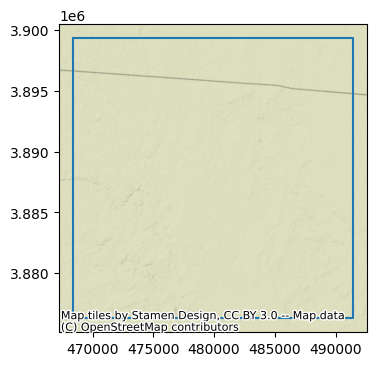

In [55]:
idx = 24

row = df.iloc[idx]
scene = row['scene']

PATH_SHP = f"../data/cloud/shapefiles/{scene}/{scene}.shp"
gdf = gpd.read_file(PATH_SHP)
display(gdf)

f = plt.figure(figsize=(4, 4))
ax = f.gca()
ax.plot(*gdf.iloc[0].geometry.exterior.xy)
cx.add_basemap(ax)

## Augmentations

In [ ]:
# augmentation
tf_dict = {
    
    'train': A.Compose(
        [

            # A.CoarseDropout(max_holes=4, max_height=4, max_width=4, 
            #                     min_holes=None, min_height=None, min_width=None, 
            #                     fill_value=0.15, mask_fill_value=0.0, always_apply=False, p=0.25),
            # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1,
            #                     border_mode=4, value=None, mask_value=None, always_apply=False,
            #                     approximate=False, same_dxdy=False, p=0.25),
            # A.GridDistortion(num_steps=5, distort_limit=0.4, interpolation=1, 
            #                     border_mode=4, value=None, mask_value=None, always_apply=False, p=0.25),
            # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, interpolation=1, 
            #                     border_mode=4, value=0.01, mask_value=0.0, shift_limit_x=None, shift_limit_y=None, 
            #                     p=0.5),
            # A.OneOf([
            #     A.GaussNoise(var_limit=(1e-4, 8e-2), mean=0., p=0.5),
            #     A.Blur(blur_limit=7, p=0.25),
            #     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=True, p=0.5),
            # ], p=0.9),
            A.Transpose(p=0.25),
            A.Flip(p=0.5),
            # A.Rotate(limit=30, p=0.5),
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
            ]
        ),
    'val': A.Compose(
        [
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
        ]
    ),
}

cfg.augmentation = str(tf_dict).replace('\n', '').replace(' ', '')
pprint(cfg.augmentation)